In [1]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

from tensorflow.keras.layers import Layer, Lambda, Conv2D, Dropout,Dense,Activation,Input,GlobalAveragePooling1D, Concatenate, GlobalAveragePooling2D, LayerNormalization, MaxPool2D
from tensorflow.keras.layers import Reshape,Flatten,BatchNormalization,MaxPooling1D,AveragePooling2D,Reshape,Attention, ReLU, Activation, SpatialDropout2D, DepthwiseConv2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold
import keras.backend as K
from tensorflow.keras.optimizers import Adam
from tqdm.auto import tqdm
import os
from Config import Config
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Mean, CategoricalAccuracy
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from datetime import datetime
import random
import matplotlib.pyplot as plt
from tensorflow.keras.losses import CategoricalCrossentropy, MeanSquaredError

import tensorflow as tf
tf.config.run_functions_eagerly(True)

import warnings
warnings.filterwarnings('always')

from my_models import *
from utils import *

In [2]:
seed_everything(42)

In [3]:
DATA_ROOT = 'TIMNET-dataset'
DATA_PATH = 'EMODB'
CLASS_LABELS = Config.EMODB_LABELS
k = 10

model_name = 'exp1-remove Dynamic-routing'
feature_name = 'mfcc'

learning_rate=0.001
beta_1=0.975
beta_2=0.932
epsilon=1e-8

EPOCHS = 300
BATCH = 32

In [4]:
class removeDWSCNN(tf.keras.Model):

  def __init__(self, dim_capsule=64, n_channels=6, kernel_size=3, strides=1, padding='valid'):
    super().__init__()
    
    self.layer = Sequential([
        Reshape(target_shape=[-1, dim_capsule]),
        Lambda(function=PrimaryCapssquash)
    ])
    
  def call(self, inputs):
    return self.layer(inputs)

In [5]:
class Model(tf.keras.Model):

  def __init__(self, num_classes):
    super().__init__()
    
    self.conv1 = Sequential([
      Conv2D(filters=64, kernel_size=3),
      BatchNormalization(axis=1),
      Activation('elu'),
      AveragePooling2D(),
      SpatialDropout2D(0.2)
    ])
    
    self.conv2 = Sequential([
      Conv2D(filters=64, kernel_size=3),
      BatchNormalization(axis=1),
      Activation('elu'),
      AveragePooling2D(),
      SpatialDropout2D(0.2),
    ])
    
    self.conv3 = Sequential([
      Conv2D(filters=64, kernel_size=3, dilation_rate=2),
      BatchNormalization(axis=1),
      Activation('elu'),
      AveragePooling2D(),
      SpatialDropout2D(0.2),
    ])
  
    # Q, V, K
    self.attention = Attention(use_scale=True)
    self.LN = LayerNormalization()
    self.lamb = Lambda(lambda x: tf.multiply(x[0], x[1]))
    
    self.cbam = CBAM(64) # sharing
    self.reshape = Reshape(target_shape=[-1, 64])
    
    self.conv4 = PrimaryCap()
    self.spatial_attn = SpatialGate()
  
    self.gap = GlobalAveragePooling1D()
    self.dropout = Dropout(0.2)
    self.classifier = Dense(num_classes, activation='softmax')
    
    
  def call(self, inputs):
    x = inputs
    forward = x
    backward = tf.reverse(inputs, axis=[2])
    
    fx = self.conv1(forward)
    fx += self.cbam(fx)
    bx = self.conv2(backward)
    bx += self.cbam(bx)
    cross_attn_out = self.attention([fx, bx, bx]) # Q, K==V
    fx += cross_attn_out
    
    fx = self.conv3(fx)
    fx += self.cbam(fx)
    
    cap = self.conv4(fx)
    cap = tf.expand_dims(cap, axis=-1)
    cap += self.spatial_attn(cap)
    cap = tf.squeeze(cap, axis=-1)
    
    sa = self.attention([cap, cap, cap])
    sa = self.LN(sa)
    
    sa = self.lamb([cap, sa])
    sa = tf.expand_dims(sa, axis=-1)
    sa += self.spatial_attn(sa)
    sa = tf.squeeze(sa, axis=-1)
    
    gap = self.gap(sa)
    drop = self.dropout(gap)
    
    output_softmax = self.classifier(drop)
    return output_softmax

In [6]:
model = Model(len(CLASS_LABELS))
model.build(input_shape=(None, 196, 39, 1))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 97, 18, 64)        1416      
                                                                 
 sequential_1 (Sequential)   (None, 97, 18, 64)        1416      
                                                                 
 sequential_2 (Sequential)   (None, 46, 7, 64)         37300     
                                                                 
 attention (Attention)       multiple                  1         
                                                                 
 layer_normalization (LayerN  multiple                 128       
 ormalization)                                                   
                                                                 
 lambda (Lambda)             multiple                  0         
                                                             

In [7]:
def margin_loss(y_true, y_pred):
    """
        Margin Loss
        :param y_true: [None, n_classes]
        :param y_pred: [None, num_capsule]
        :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

In [8]:
@tf.function
def train_step(model, optimizer, x, labels):
    with tf.GradientTape() as tape:
        # 미분 계산
        predictions = model(x, training=True)
        loss1 = margin_loss(labels, predictions)
        loss2 = MeanSquaredError()(labels, predictions)
        
        loss = loss1*1. + loss2*0.392
        
    grad = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grad, model.trainable_variables))     # 신경망 파라미터 업데이트
    
    acc = tf.keras.metrics.CategoricalAccuracy()
    acc.update_state(labels, predictions)
    accuracy = acc.result().numpy()
    
    return loss, accuracy*100

def test_step(model, x, labels):
    predictions = model(x)
    loss1 = margin_loss(labels, predictions)
    loss2 = MeanSquaredError()(labels, predictions)
    loss = loss1*1. + loss2*0.392
    
    acc = tf.keras.metrics.CategoricalAccuracy()
    acc.update_state(labels, predictions)
    accuracy = acc.result().numpy()
    
    return loss, accuracy*100, predictions

In [9]:
# Read data
with open(f'{DATA_ROOT}/{DATA_PATH}.npy', 'rb') as f:
    x = np.load(f)
    y = np.load(f)

y = to_categorical(y,num_classes=len(CLASS_LABELS))

In [10]:
LEARNING_RATE_DECAY_PARAMETERS = -0.15
LEARNING_RATE_DECAY_STRATPOINT = 50
LEARNING_RATE_DECAY_STEP = 20


def scheduler(epoch, lr):
    if epoch < LEARNING_RATE_DECAY_STRATPOINT:
        return lr
    else:
        if epoch % LEARNING_RATE_DECAY_STEP == 0:
            lr = lr * tf.math.exp(LEARNING_RATE_DECAY_PARAMETERS)
    return lr

In [11]:
# Smooth label operation
def smooth_labels(labels, factor=0.1):
    """
        smooth the labels
        returned the smoothed labels
    """
    labels *= (1 - factor)
    labels += (factor / labels.shape[1])
    return labels

In [12]:
from discord_notice import start, end
# start()

A Jupyter Widget

A Jupyter Widget

1/300 lr=0.00100 - loss:0.603, acc:22.070, val_loss:0.631, val_acc:23.864
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:0.575, acc:22.852, val_loss:0.525, val_acc:23.864
Best loss:0.631, Best accuracy:23.864, Best F1-score:0.092
3/300 lr=0.00100 - loss:0.564, acc:30.078, val_loss:0.509, val_acc:40.057
Best loss:0.631, Best accuracy:23.864, Best F1-score:0.092
4/300 lr=0.00100 - loss:0.526, acc:40.039, val_loss:0.483, val_acc:50.852
Best loss:0.509, Best accuracy:40.057, Best F1-score:0.286
5/300 lr=0.00100 - loss:0.515, acc:41.016, val_loss:0.465, val_acc:46.165
Best loss:0.483, Best accuracy:50.852, Best F1-score:0.373
6/300 lr=0.00100 - loss:0.504, acc:36.328, val_loss:0.456, val_acc:47.727
Best loss:0.483, Best accuracy:50.852, Best F1-score:0.373
7/300 lr=0.00100 - loss:0.488, acc:44.336, val_loss:0.453, val_acc:47.017
Best loss:0.483, Best accuracy:50.852, Best F1-score:0.373
8/300 lr=0.00100 - loss:0.473, acc:44.727, val_loss:0.438, val

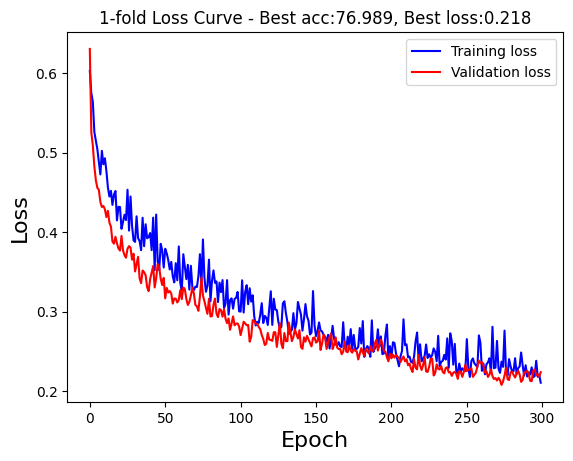

A Jupyter Widget

1/300 lr=0.00100 - loss:0.587, acc:33.398, val_loss:0.491, val_acc:46.165
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:0.551, acc:32.227, val_loss:0.433, val_acc:46.165
Best loss:0.491, Best accuracy:46.165, Best F1-score:0.306
3/300 lr=0.00100 - loss:0.536, acc:35.547, val_loss:0.423, val_acc:55.398
Best loss:0.491, Best accuracy:46.165, Best F1-score:0.306
4/300 lr=0.00100 - loss:0.495, acc:44.336, val_loss:0.426, val_acc:54.688
Best loss:0.423, Best accuracy:55.398, Best F1-score:0.436
5/300 lr=0.00100 - loss:0.504, acc:40.234, val_loss:0.411, val_acc:56.960
Best loss:0.423, Best accuracy:55.398, Best F1-score:0.436
6/300 lr=0.00100 - loss:0.510, acc:37.891, val_loss:0.413, val_acc:53.977
Best loss:0.411, Best accuracy:56.960, Best F1-score:0.449
7/300 lr=0.00100 - loss:0.503, acc:41.406, val_loss:0.427, val_acc:49.432
Best loss:0.411, Best accuracy:56.960, Best F1-score:0.449
8/300 lr=0.00100 - loss:0.476, acc:47.461, val_loss:0.404, val

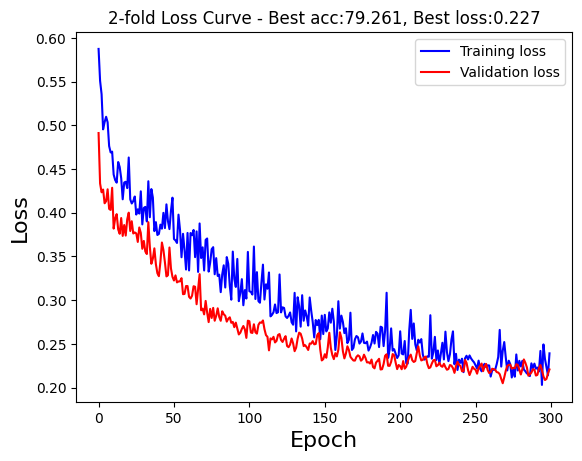

A Jupyter Widget

1/300 lr=0.00100 - loss:0.602, acc:21.484, val_loss:0.561, val_acc:31.534
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:0.539, acc:39.453, val_loss:0.520, val_acc:38.494
Best loss:0.561, Best accuracy:31.534, Best F1-score:0.162
3/300 lr=0.00100 - loss:0.528, acc:33.789, val_loss:0.479, val_acc:42.330
Best loss:0.520, Best accuracy:38.494, Best F1-score:0.252
4/300 lr=0.00100 - loss:0.510, acc:36.523, val_loss:0.459, val_acc:47.727
Best loss:0.479, Best accuracy:42.330, Best F1-score:0.278
5/300 lr=0.00100 - loss:0.498, acc:42.188, val_loss:0.457, val_acc:40.767
Best loss:0.459, Best accuracy:47.727, Best F1-score:0.336
6/300 lr=0.00100 - loss:0.503, acc:38.281, val_loss:0.451, val_acc:35.369
Best loss:0.459, Best accuracy:47.727, Best F1-score:0.336
7/300 lr=0.00100 - loss:0.471, acc:44.922, val_loss:0.435, val_acc:49.858
Best loss:0.459, Best accuracy:47.727, Best F1-score:0.336
8/300 lr=0.00100 - loss:0.492, acc:41.797, val_loss:0.422, val

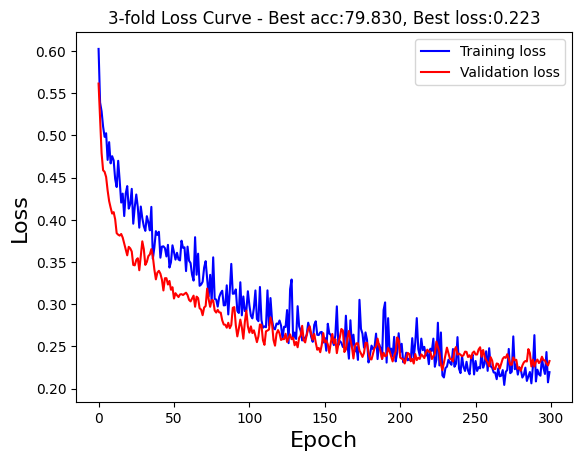

A Jupyter Widget

1/300 lr=0.00100 - loss:0.605, acc:23.438, val_loss:0.540, val_acc:35.369
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:0.570, acc:29.297, val_loss:0.463, val_acc:48.438
Best loss:0.540, Best accuracy:35.369, Best F1-score:0.187
3/300 lr=0.00100 - loss:0.540, acc:33.203, val_loss:0.428, val_acc:54.545
Best loss:0.463, Best accuracy:48.438, Best F1-score:0.388
4/300 lr=0.00100 - loss:0.529, acc:35.742, val_loss:0.436, val_acc:49.290
Best loss:0.428, Best accuracy:54.545, Best F1-score:0.417
5/300 lr=0.00100 - loss:0.519, acc:40.039, val_loss:0.442, val_acc:42.330
Best loss:0.428, Best accuracy:54.545, Best F1-score:0.417
6/300 lr=0.00100 - loss:0.516, acc:40.430, val_loss:0.439, val_acc:45.455
Best loss:0.428, Best accuracy:54.545, Best F1-score:0.417
7/300 lr=0.00100 - loss:0.519, acc:40.820, val_loss:0.437, val_acc:48.438
Best loss:0.428, Best accuracy:54.545, Best F1-score:0.417
8/300 lr=0.00100 - loss:0.470, acc:45.508, val_loss:0.434, val

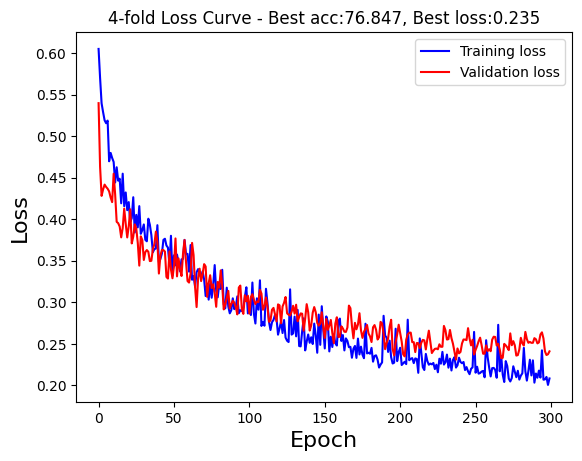

A Jupyter Widget

1/300 lr=0.00100 - loss:0.583, acc:30.664, val_loss:0.572, val_acc:36.222
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:0.529, acc:35.156, val_loss:0.531, val_acc:38.494
Best loss:0.572, Best accuracy:36.222, Best F1-score:0.227
3/300 lr=0.00100 - loss:0.546, acc:32.422, val_loss:0.512, val_acc:38.494
Best loss:0.531, Best accuracy:38.494, Best F1-score:0.221
4/300 lr=0.00100 - loss:0.501, acc:42.969, val_loss:0.505, val_acc:41.619
Best loss:0.531, Best accuracy:38.494, Best F1-score:0.221
5/300 lr=0.00100 - loss:0.510, acc:44.336, val_loss:0.492, val_acc:37.784
Best loss:0.505, Best accuracy:41.619, Best F1-score:0.278
6/300 lr=0.00100 - loss:0.484, acc:46.484, val_loss:0.486, val_acc:37.784
Best loss:0.505, Best accuracy:41.619, Best F1-score:0.278
7/300 lr=0.00100 - loss:0.489, acc:41.211, val_loss:0.481, val_acc:41.619
Best loss:0.505, Best accuracy:41.619, Best F1-score:0.278
8/300 lr=0.00100 - loss:0.506, acc:39.062, val_loss:0.482, val

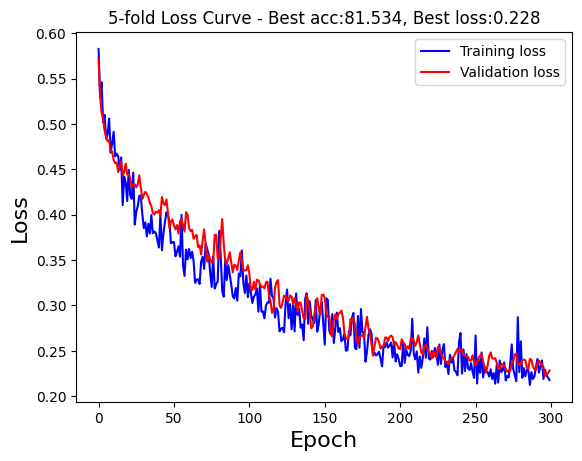

A Jupyter Widget

1/300 lr=0.00100 - loss:0.596, acc:30.664, val_loss:0.594, val_acc:23.586
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:0.546, acc:33.984, val_loss:0.555, val_acc:28.348
Best loss:0.594, Best accuracy:23.586, Best F1-score:0.118
3/300 lr=0.00100 - loss:0.514, acc:39.453, val_loss:0.537, val_acc:32.292
Best loss:0.555, Best accuracy:28.348, Best F1-score:0.154
4/300 lr=0.00100 - loss:0.487, acc:44.922, val_loss:0.516, val_acc:33.854
Best loss:0.537, Best accuracy:32.292, Best F1-score:0.235
5/300 lr=0.00100 - loss:0.491, acc:38.672, val_loss:0.506, val_acc:35.342
Best loss:0.516, Best accuracy:33.854, Best F1-score:0.233
6/300 lr=0.00100 - loss:0.489, acc:43.164, val_loss:0.495, val_acc:38.467
Best loss:0.506, Best accuracy:35.342, Best F1-score:0.263
7/300 lr=0.00100 - loss:0.478, acc:45.703, val_loss:0.497, val_acc:41.592
Best loss:0.495, Best accuracy:38.467, Best F1-score:0.303
8/300 lr=0.00100 - loss:0.473, acc:46.484, val_loss:0.489, val

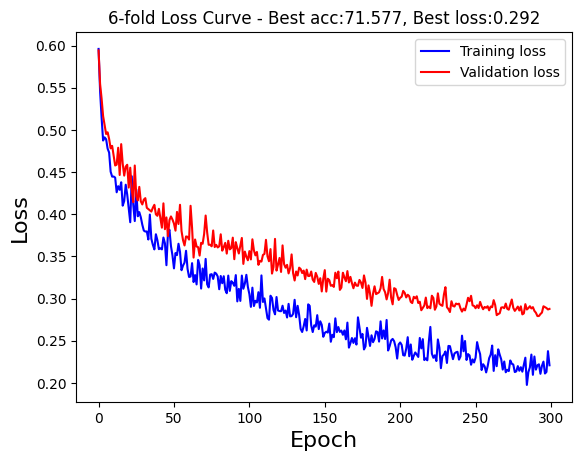

A Jupyter Widget

1/300 lr=0.00100 - loss:0.609, acc:21.484, val_loss:0.581, val_acc:16.518
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:0.566, acc:30.273, val_loss:0.525, val_acc:34.673
Best loss:0.581, Best accuracy:16.518, Best F1-score:0.099
3/300 lr=0.00100 - loss:0.523, acc:38.477, val_loss:0.501, val_acc:33.929
Best loss:0.525, Best accuracy:34.673, Best F1-score:0.198
4/300 lr=0.00100 - loss:0.503, acc:40.234, val_loss:0.490, val_acc:39.435
Best loss:0.525, Best accuracy:34.673, Best F1-score:0.198
5/300 lr=0.00100 - loss:0.475, acc:44.922, val_loss:0.480, val_acc:36.310
Best loss:0.490, Best accuracy:39.435, Best F1-score:0.262
6/300 lr=0.00100 - loss:0.492, acc:40.625, val_loss:0.468, val_acc:43.452
Best loss:0.490, Best accuracy:39.435, Best F1-score:0.262
7/300 lr=0.00100 - loss:0.470, acc:44.922, val_loss:0.448, val_acc:45.015
Best loss:0.468, Best accuracy:43.452, Best F1-score:0.315
8/300 lr=0.00100 - loss:0.467, acc:48.047, val_loss:0.442, val

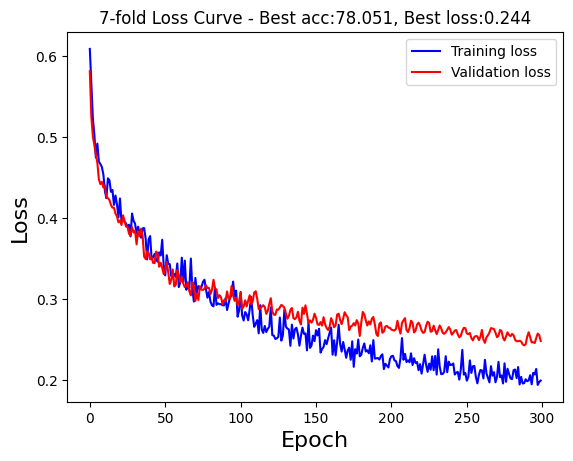

A Jupyter Widget

1/300 lr=0.00100 - loss:0.586, acc:27.930, val_loss:0.716, val_acc:14.137
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:0.553, acc:32.812, val_loss:0.572, val_acc:29.836
Best loss:0.716, Best accuracy:14.137, Best F1-score:0.038
3/300 lr=0.00100 - loss:0.538, acc:35.352, val_loss:0.573, val_acc:36.161
Best loss:0.572, Best accuracy:29.836, Best F1-score:0.160
4/300 lr=0.00100 - loss:0.512, acc:41.406, val_loss:0.508, val_acc:40.104
Best loss:0.573, Best accuracy:36.161, Best F1-score:0.268
5/300 lr=0.00100 - loss:0.502, acc:41.992, val_loss:0.494, val_acc:36.161
Best loss:0.508, Best accuracy:40.104, Best F1-score:0.270
6/300 lr=0.00100 - loss:0.492, acc:40.430, val_loss:0.441, val_acc:51.860
Best loss:0.508, Best accuracy:40.104, Best F1-score:0.270
7/300 lr=0.00100 - loss:0.464, acc:47.461, val_loss:0.426, val_acc:62.128
Best loss:0.441, Best accuracy:51.860, Best F1-score:0.432
8/300 lr=0.00100 - loss:0.456, acc:46.680, val_loss:0.425, val

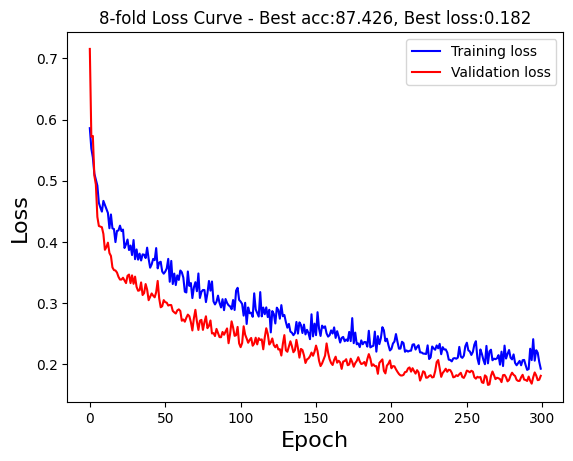

A Jupyter Widget

1/300 lr=0.00100 - loss:0.601, acc:22.656, val_loss:0.612, val_acc:22.024
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:0.559, acc:33.398, val_loss:0.630, val_acc:17.336
Best loss:0.612, Best accuracy:22.024, Best F1-score:0.118
3/300 lr=0.00100 - loss:0.514, acc:37.891, val_loss:0.586, val_acc:17.336
Best loss:0.612, Best accuracy:22.024, Best F1-score:0.118
4/300 lr=0.00100 - loss:0.503, acc:40.039, val_loss:0.558, val_acc:26.711
Best loss:0.612, Best accuracy:22.024, Best F1-score:0.118
5/300 lr=0.00100 - loss:0.494, acc:40.820, val_loss:0.562, val_acc:23.586
Best loss:0.558, Best accuracy:26.711, Best F1-score:0.158
6/300 lr=0.00100 - loss:0.482, acc:42.383, val_loss:0.542, val_acc:33.780
Best loss:0.558, Best accuracy:26.711, Best F1-score:0.158
7/300 lr=0.00100 - loss:0.489, acc:45.312, val_loss:0.542, val_acc:32.961
Best loss:0.542, Best accuracy:33.780, Best F1-score:0.230
8/300 lr=0.00100 - loss:0.459, acc:50.586, val_loss:0.538, val

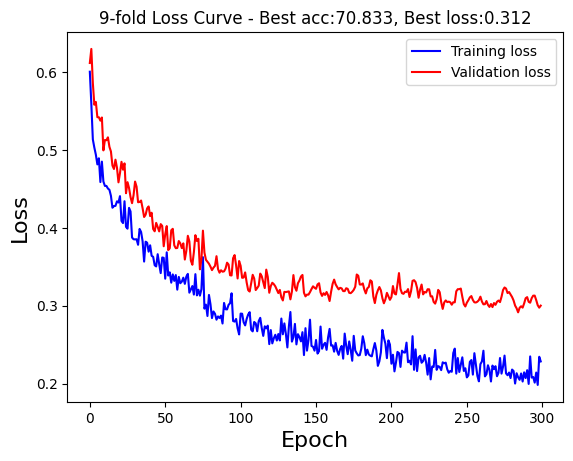

A Jupyter Widget

1/300 lr=0.00100 - loss:0.598, acc:29.102, val_loss:0.518, val_acc:43.304
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:0.539, acc:36.523, val_loss:0.475, val_acc:40.923
Best loss:0.518, Best accuracy:43.304, Best F1-score:0.299
3/300 lr=0.00100 - loss:0.537, acc:36.719, val_loss:0.457, val_acc:42.485
Best loss:0.518, Best accuracy:43.304, Best F1-score:0.299
4/300 lr=0.00100 - loss:0.520, acc:39.258, val_loss:0.444, val_acc:50.372
Best loss:0.518, Best accuracy:43.304, Best F1-score:0.299
5/300 lr=0.00100 - loss:0.494, acc:42.969, val_loss:0.443, val_acc:49.554
Best loss:0.444, Best accuracy:50.372, Best F1-score:0.363
6/300 lr=0.00100 - loss:0.496, acc:41.602, val_loss:0.433, val_acc:49.554
Best loss:0.444, Best accuracy:50.372, Best F1-score:0.363
7/300 lr=0.00100 - loss:0.472, acc:48.438, val_loss:0.430, val_acc:55.878
Best loss:0.444, Best accuracy:50.372, Best F1-score:0.363
8/300 lr=0.00100 - loss:0.487, acc:43.359, val_loss:0.416, val

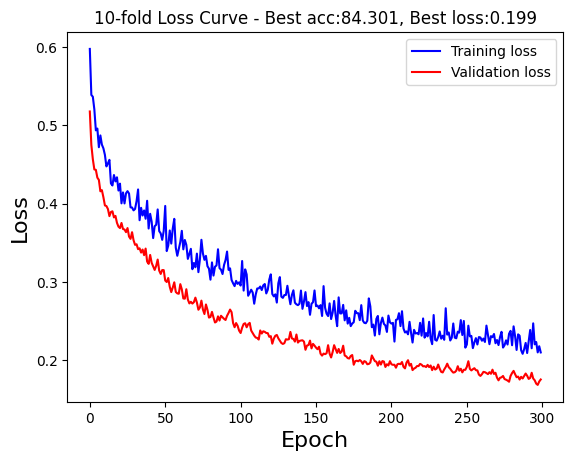

In [13]:
import tensorflow_addons as tfa
from keras.models import load_model

emotions_groundtruth_list = np.array([])
predicted_emotions_list = np.array([])

fold_acc = []

kfold = KFold(n_splits=k, shuffle=True, random_state=98)

for i, (train, test) in tqdm(enumerate(kfold.split(x, y)), desc=f'Training {k}-Fold.....'):
    save_path = f'Models/{DATA_PATH}'
    os.makedirs(save_path, exist_ok=True)
    h5_path = f'{save_path}/{model_name}_{i}-fold_.h5'
    
    x_train, y_train = x[train], y[train]
    y_train = smooth_labels(y[train], 0.1)
    
    x_test, y_test = x[test], y[test]
    
    x_train = tf.expand_dims(x_train, axis=-1)
    x_test = tf.expand_dims(x_test, axis=-1)
    
    shape = x_train.shape[1:]
    
    optimizer = Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
    
    model = Model(len(CLASS_LABELS))
    
    best_test_loss = 0x3f3f3f
    best_test_acc = -1
    best_test_f1 = -1
    
    epoch_losses = []
    valid_losses = []
    
    batch_train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(2022).batch(BATCH)
    batch_test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH)
    for epoch in tqdm(range(EPOCHS), desc=f'Fold-{i+1}'):

        train_loss, train_acc = [], []
        for features, labels in batch_train:
            loss, acc = train_step(model, optimizer, features, labels)
            train_loss.append(loss)
            train_acc.append(acc)
            
        test_loss, test_acc, f1s = [], [], []
        for features, labels in batch_test:
            loss, acc, pred = test_step(model, features, labels)
            test_loss.append(loss)
            test_acc.append(acc)
            
            f1_metric = tfa.metrics.F1Score(num_classes=len(CLASS_LABELS), average='weighted')
            f1_metric.update_state(labels, pred)
            f1 = f1_metric.result().numpy()
            f1s.append(f1)
            
        
        epoch_loss = sum(train_loss)/len(train_loss)
        epoch_acc = sum(train_acc)/len(train_acc)
        val_loss = sum(test_loss)/len(test_loss)
        val_acc = sum(test_acc)/len(test_acc)
        f1_score = sum(f1s)/len(f1s)
        
        epoch_losses.append(epoch_loss)
        valid_losses.append(val_loss)
        
        cur_lr = K.eval(optimizer.lr)
        print(f'{epoch+1}/{EPOCHS} lr={cur_lr:.5f} - loss:{epoch_loss:.3f}, acc:{epoch_acc:.3f}, val_loss:{val_loss:.3f}, val_acc:{val_acc:.3f}')
        print(f'Best loss:{best_test_loss:.3f}, Best accuracy:{best_test_acc:.3f}, Best F1-score:{best_test_f1:.3f}')
        
        set_lr = scheduler(epoch, K.eval(optimizer.lr))
        K.set_value(optimizer.learning_rate, set_lr)
        
        if best_test_acc < val_acc:
            best_test_acc = val_acc
            best_test_loss = val_loss
            best_test_f1 = f1_score
            model.save_weights(h5_path)
            
            
    model = Model(len(CLASS_LABELS))
    model.build(input_shape=x_train.shape)
    model.load_weights(h5_path)
    
    for features, labels in batch_test:
        best_pred = model(features, training=False)
        emotions_groundtruth_list = np.append(emotions_groundtruth_list, np.argmax(labels, axis=1))
        predicted_emotions_list = np.append(predicted_emotions_list, np.argmax(best_pred, axis=1))
    
    
    print(f'[*] Done - acc:{best_test_acc:.3f}')
    
    plt.title(f'{i+1}-fold Loss Curve - Best acc:{best_test_acc:.3f}, Best loss:{best_test_loss:.3f}')
    plt.ylabel('Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.plot(epoch_losses[:],'b')
    plt.plot(valid_losses[:],'r')
    plt.legend(['Training loss','Validation loss'])

    
    save_fig_path = f'Fig/{DATA_PATH}/training/{model_name}'
    os.makedirs(save_fig_path, exist_ok=True)
    plt.savefig(f'{save_fig_path}/{i+1}-fold.PNG')
    
    plt.show()
    
    fold_acc.append(best_test_acc)

In [14]:
end()

In [15]:
print(f'max:{max(fold_acc)}, min:{min(fold_acc)}, average:{sum(fold_acc)/len(fold_acc)}')

max:87.42559552192688, min:70.83333432674408, average:78.66477310657501


In [16]:
import warnings
warnings.filterwarnings('always')

Report = classification_report(emotions_groundtruth_list, predicted_emotions_list)

os.makedirs(f'Results/{DATA_PATH}', exist_ok=True)
report_path = f'Results/{DATA_PATH}/{model_name}_{feature_name}_{k}-fold_nomalize.txt'

with open(report_path, "w") as f:
    f.write(Report)

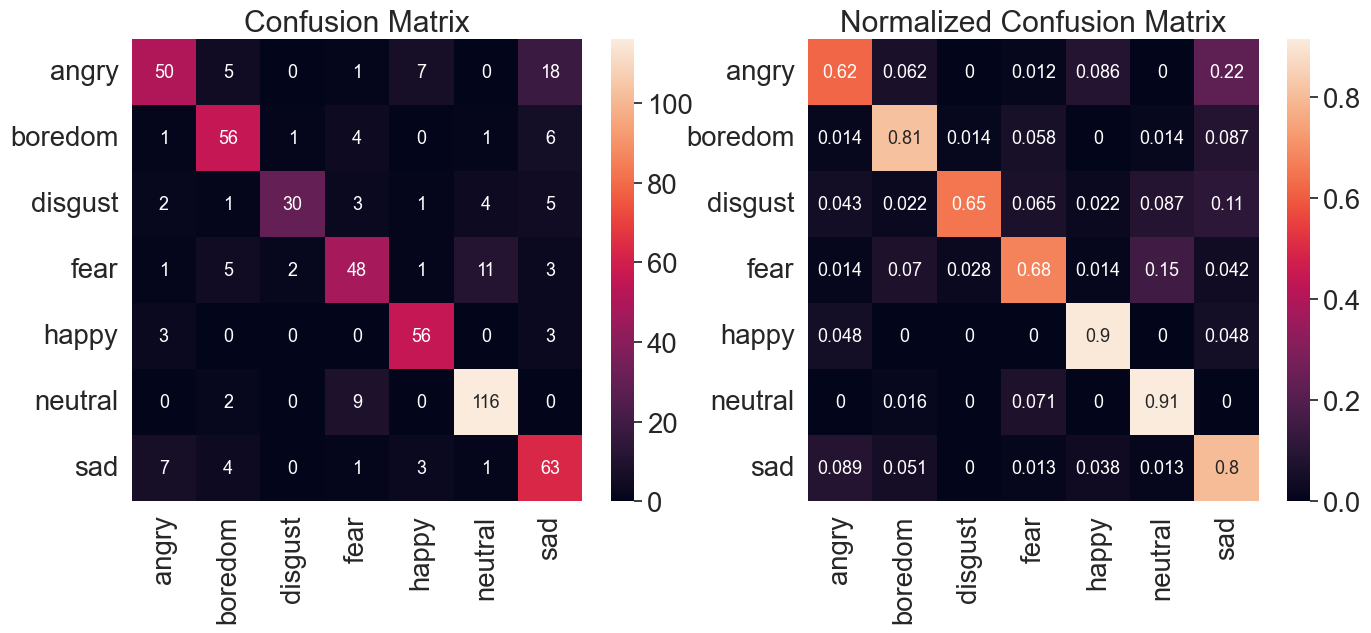

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

emotion_names = CLASS_LABELS


# build confusion matrix and normalized confusion matrix
conf_matrix = confusion_matrix(emotions_groundtruth_list, predicted_emotions_list)
conf_matrix_norm = confusion_matrix(emotions_groundtruth_list, predicted_emotions_list,normalize='true')

# make a confusion matrix with labels using a DataFrame
confmatrix_df = pd.DataFrame(conf_matrix, index=emotion_names, columns=emotion_names)
confmatrix_df_norm = pd.DataFrame(conf_matrix_norm, index=emotion_names, columns=emotion_names)

# plot confusion matrices
plt.figure(figsize=(16,6))
sn.set(font_scale=1.8) # emotion label and title size
plt.subplot(1,2,1)
plt.title('Confusion Matrix')
sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 13}, fmt='g') #annot_kws is value font
plt.subplot(1,2,2)
plt.title('Normalized Confusion Matrix')
sn.heatmap(confmatrix_df_norm, annot=True, annot_kws={"size": 13}) #annot_kws is value font
plt.savefig(f'Results/{DATA_PATH}/{model_name}_{feature_name}_{k}-fold_confmatrix.pdf')
plt.show()

In [18]:
get_metric_calc(conf_matrix)

WAR(Weighted Average Recall)   : 76.73%
UAR(Unweighted Average Recall) : 76.73%
